# Optional Project - 2 (Addition - Feature Cross)

By Eda AYDIN

- Chi-Square test sonucunda CDRGLOB ile nominal sütunların p değeri 0.05 değerinden büyük olan `['NACCFAM', 'ANYMEDS', 'NACCTBI', 'DIABETES']` sütunlar modele dahil edilmedi.
- NACCAGEB ile sayısal sütunların birbiri ile olan ilişkisi ANOVA test ile incelendi.
- Bunun sonucunda p değeri 0.05 değerinden büyük olan `['MARISTAT','NACCAPOE','LFUSM','LINSULAM','LLATOCCM','LMIDTEMM','LPRECUNM','LSUPPARM','LSUPMARM','RCAC','RFUSM','RINFPARM','RINSULAM','RLATOCCM','RMEDORBM','RPARSOPM','RPARORBM','RPARTRIM','RPRECUNM']` olan sütunlarla feature cross işlemi yapılmadı.
- Toplamda 140 sütun ile NACCAGEB sütunu arasında feature cross yapıldı.
- Model olarak sinir ağı kullanılıp aşağıdaki sonuçlar elde edilmiştir.
  - Validation datasında 0.77 f1-score 
  - Test datasında 0.75 f1-score


Sonraki aşama? 
- TensorFlow kullanarak feature_cross işlemi yapmaya çalıştım ama boyut anlamında sorun yaşadım. O yüzden o kısımdan devam etmedim ama üzerinde çalışacağım. 
- Tekrar bakılacak olan Google Colab dosyası : [link](https://colab.research.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/representation_with_a_feature_cross.ipynb?utm_source=mlcc&utm_campaign=colab-external&utm_medium=referral&utm_content=representation_tf2-colab&hl=tr#scrollTo=9n9_cTveKmse)
                    

In [1]:
import pandas as pd
import tensorflow as tf
from fast_ml.model_development import train_valid_test_split
import numpy as np

In [2]:

data = pd.read_excel("data/data.xlsx")

In [3]:
target = "CDRGLOB"

In [4]:
data.head()

,SEX,EDUC,MARISTAT,INDEPEND,RESIDENC,NACCFAM,ANYMEDS,SMOKYRS,NACCTBI,DIABETES,...,RSUPFR,RSUPFRM,RSUPPAR,RSUPPARM,RSUPTEM,RSUPTEMM,RSUPMAR,RSUPMARM,RTRTEM,RTRTEMM
0,2,18,1,1,1,1,1,0,0,0,...,27.9038,2.2157,10.3481,1.7014,13.4250,1.7419,9.8700,1.6792,0.8906,1.1947
1,1,11,1,1,1,1,1,0,0,0,...,29.0600,2.6900,9.2500,1.6300,14.8800,2.3000,7.2700,1.8900,1.3800,2.0300
2,2,16,1,1,1,1,1,10,0,1,...,33.0000,2.5400,13.6900,1.5600,16.2300,2.0700,10.1100,1.8400,1.0100,1.5000
3,1,14,1,1,1,0,1,0,0,1,...,31.6800,2.4100,9.6400,1.4500,15.1100,1.6400,10.3900,1.8300,0.7400,1.1000
4,1,16,1,1,2,0,1,50,0,0,...,28.0631,1.9501,9.1125,1.0427,13.3763,1.6270,7.5844,1.4595,0.6638,0.8527


In [5]:
def grab_col_names(dataframe, categorical_threshold=10, cardinal_threshold=20):
    """
    It gives the names of categorical, numerical and categorical but cardinal,nominal variables in the data set.
    Note: Categorical variables but numerical variables are also included in categorical variables.

    Parameters
    ----------
    dataframe : dataframe
        The dataframe from which variables names are to be retrieved.
    categorical_threshold : int, optional
        class threshold for numeric but categorical variables
    cardinal_threshold : int, optional
        Class threshold for categorical but cardinal variables

    Returns
    -------
        categorical_cols : list
            Categorical variable list
        numerical_cols : list
            Numerical variable list
        cardinal_cols : list
            Categorical looking cardinal variable list

    Examples
    -------
        import seaborn as sns
        df = sns.load_titanic_dataset("iris")
        print(grab_col_names(df))

    Notes
    -------
        categorical_cols + numerical_cols + cardinal_cols = total number of variables.
        nominal_cols is inside categorical_cols
        The sum of the 3 returned lists equals the total number of variables: categorical_cols + cardinal_cols = number of variables

    """

    categorical_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    nominal_cols = [col for col in dataframe.columns if
                    dataframe[col].nunique() < categorical_threshold and dataframe[col].dtypes != "O"]
    cardinal_cols = [col for col in dataframe.columns if
                     dataframe[col].nunique() > cardinal_threshold and dataframe[col].dtypes == "O"]
    categorical_cols = categorical_cols + nominal_cols
    categorical_cols = [col for col in categorical_cols if col not in cardinal_cols]

    # numerical_cols
    numerical_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    numerical_cols = [col for col in numerical_cols if col not in categorical_cols]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'categorical_cols: {len(categorical_cols)}')
    print(f'numerical_cols: {len(numerical_cols)}')
    print(f'cardinal_cols: {len(cardinal_cols)}')
    print(f'nominal_cols: {len(nominal_cols)}')
    return categorical_cols, numerical_cols, cardinal_cols, nominal_cols

In [6]:
# Değişken türlerin ayrıştırılması
categorical_cols, numerical_cols, cardinal_cols, nominal_cols = grab_col_names(data, categorical_threshold=5, cardinal_threshold=20)

Observations: 1354
Variables: 186
categorical_cols: 27
numerical_cols: 159
cardinal_cols: 0
nominal_cols: 27


In [7]:
def chi2_by_hand(df, col1, col2):
    #---create the contingency table---
    df_cont = pd.crosstab(index = df[col1], columns = df[col2])
    display(df_cont)
    #---calculate degree of freedom---
    degree_f = (df_cont.shape[0]-1) * (df_cont.shape[1]-1)
    #---sum up the totals for row and columns---
    df_cont.loc[:,'Total']= df_cont.sum(axis=1)
    df_cont.loc['Total']= df_cont.sum()

    #---create the expected value dataframe---
    df_exp = df_cont.copy()
    df_exp.iloc[:,:] = np.multiply.outer(
        df_cont.sum(1).values,df_cont.sum().values) / df_cont.sum().sum()

    # calculate chi-square values
    df_chi2 = ((df_cont - df_exp)**2) / df_exp
    df_chi2.loc[:,'Total']= df_chi2.sum(axis=1)
    df_chi2.loc['Total']= df_chi2.sum()

    #---get chi-square score---
    chi_square_score = df_chi2.iloc[:-1,:-1].sum().sum()

    #---calculate the p-value---
    from scipy import stats
    p = stats.distributions.chi2.sf(chi_square_score, degree_f)

    return chi_square_score, degree_f, p

In [8]:
nominal_cols_for_exclude = []

for col in nominal_cols:
    chi_score, degree_f, p = chi2_by_hand(data,col,target)
    if p >= 0.05:
        nominal_cols_for_exclude.append(col)
    else:
        print(f'Chi2_score: {chi_score}, Degrees of freedom: {degree_f}, p-value: {p}')

CDRGLOB,0,1,2,3
SEX,,,,
1,214,243,93,27
2,432,253,72,20


Chi2_score: 49.01069368186929, Degrees of freedom: 3, p-value: 1.2976371186897332e-10


CDRGLOB,0,1,2,3
INDEPEND,,,,
1,641,335,36,1
2,5,149,98,11
3,0,11,31,27
4,0,1,0,8


Chi2_score: 981.2582820042857, Degrees of freedom: 9, p-value: 1.8948144474497572e-205


CDRGLOB,0,1,2,3
RESIDENC,,,,
1,577,453,150,39
2,66,39,9,5
3,3,4,6,1
4,0,0,0,2


Chi2_score: 73.89908863327474, Degrees of freedom: 9, p-value: 2.6058415446167625e-12


CDRGLOB,0,1,2,3
NACCFAM,,,,
0,227,192,59,21
1,419,304,106,26


CDRGLOB,0,1,2,3
ANYMEDS,,,,
0,36,22,5,1
1,610,474,160,46


CDRGLOB,0,1,2,3
NACCTBI,,,,
0,570,431,139,42
1,76,65,26,5


CDRGLOB,0,1,2,3
DIABETES,,,,
0,539,400,136,39
1,95,91,26,7
2,12,5,3,1


CDRGLOB,0,1,2,3
ALCOHOL,,,,
0,620,466,155,41
1,6,5,3,3
2,20,25,7,3


Chi2_score: 14.76530391992098, Degrees of freedom: 6, p-value: 0.022162807331531913


CDRGLOB,0,1,2,3
HXHYPER,,,,
0,336,174,60,15
1,310,322,105,32


Chi2_score: 39.35167271265891, Degrees of freedom: 3, p-value: 1.4620353052582943e-08


CDRGLOB,0,1,2,3
HYPERCHO,,,,
0,294,179,62,17
1,332,296,99,25
2,20,21,4,5


Chi2_score: 18.926200119644218, Degrees of freedom: 6, p-value: 0.004290102095295045


CDRGLOB,0,1,2,3
HXSTROKE,,,,
0,628,456,156,44
2,18,40,9,3


Chi2_score: 16.131180826178756, Degrees of freedom: 3, p-value: 0.0010658763106597257


CDRGLOB,0,1,2,3
FOCLSIGN,,,,
0,624,460,158,46
2,22,36,7,1


Chi2_score: 9.990440140508364, Degrees of freedom: 3, p-value: 0.0186475728107582


CDRGLOB,0,1,2,3
CDRGLOB,,,,
0,646,0,0,0
1,0,496,0,0
2,0,0,165,0
3,0,0,0,47


Chi2_score: 4062.0, Degrees of freedom: 9, p-value: 0.0


CDRGLOB,0,1,2,3
DEL,,,,
0,645,479,138,35
1,1,17,27,12


Chi2_score: 140.52382427718504, Degrees of freedom: 3, p-value: 2.9141541401202638e-30


CDRGLOB,0,1,2,3
HALL,,,,
0,645,492,148,41
1,1,4,17,6


Chi2_score: 97.3864460875671, Degrees of freedom: 3, p-value: 5.6674017872888634e-21


CDRGLOB,0,1,2,3
AGIT,,,,
0,619,387,98,23
1,27,109,67,24


Chi2_score: 189.80784093421696, Degrees of freedom: 3, p-value: 6.716119693841997e-41


CDRGLOB,0,1,2,3
DEPD,,,,
0,583,325,90,31
1,63,171,75,16


Chi2_score: 145.96198561259035, Degrees of freedom: 3, p-value: 1.9577754925125277e-31


CDRGLOB,0,1,2,3
ANX,,,,
0,594,363,87,29
1,52,133,78,18


Chi2_score: 153.82512078112293, Degrees of freedom: 3, p-value: 3.94048246006371e-33


CDRGLOB,0,1,2,3
ELAT,,,,
0,644,482,155,47
1,2,14,10,0


Chi2_score: 26.981114575047023, Degrees of freedom: 3, p-value: 5.941271773974261e-06


CDRGLOB,0,1,2,3
APA,,,,
0,635,383,83,23
1,11,113,82,24


Chi2_score: 282.7319659357862, Degrees of freedom: 3, p-value: 5.428616758593962e-61


CDRGLOB,0,1,2,3
DISN,,,,
0,641,432,124,31
1,5,64,41,16


Chi2_score: 144.62675758382238, Degrees of freedom: 3, p-value: 3.799577719242381e-31


CDRGLOB,0,1,2,3
IRR,,,,
0,599,341,97,27
1,47,155,68,20


Chi2_score: 156.1409700278583, Degrees of freedom: 3, p-value: 1.2470183456462334e-33


CDRGLOB,0,1,2,3
MOT,,,,
0,645,462,135,30
1,1,34,30,17


Chi2_score: 157.65646124171428, Degrees of freedom: 3, p-value: 5.872990770035207e-34


CDRGLOB,0,1,2,3
NITE,,,,
0,599,392,105,27
1,47,104,60,20


Chi2_score: 114.09862420501912, Degrees of freedom: 3, p-value: 1.439250238133758e-24


CDRGLOB,0,1,2,3
APP,,,,
0,623,409,118,33
1,23,87,47,14


Chi2_score: 109.12410206405058, Degrees of freedom: 3, p-value: 1.693671679216208e-23


CDRGLOB,0,1,2,3
DROPACT,,,,
0,589,389,121,33
1,57,107,44,14


Chi2_score: 55.56617819660625, Degrees of freedom: 3, p-value: 5.198978486007247e-12


CDRGLOB,0,1,2,3
NACCNE4S,,,,
0,444,269,75,26
1,185,181,68,19
2,17,46,22,2


Chi2_score: 59.740742731532464, Degrees of freedom: 6, p-value: 5.081263765825434e-11


In [9]:
nominal_cols_for_exclude

['NACCFAM', 'ANYMEDS', 'NACCTBI', 'DIABETES']

In [10]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

numerical_cols_for_exclude = []

for col in numerical_cols:
    model = ols("NACCAGEB" + '~' + col, data = data).fit() #Ordinary least square method
    result_anova = sm.stats.anova_lm(model, typ = 2) # ANOVA Test
    if result_anova.loc[col]["PR(>F)"] >= 0.05: 
        numerical_cols_for_exclude.append(col) # Save column names with pi-value greater than 0.05
    else:
        print(result_anova)
        print("\n")

                 sum_sq      df         F   PR(>F)
EDUC         745.638770     1.0  7.735345  0.00549
Residual  130324.320609  1352.0       NaN      NaN


                 sum_sq      df         F    PR(>F)
SMOKYRS      868.417978     1.0  9.017567  0.002723
Residual  130201.541401  1352.0       NaN       NaN


                 sum_sq      df         F        PR(>F)
HACHIN      7500.617044     1.0  82.06594  4.487036e-19
Residual  123569.342335  1352.0       NaN           NaN


                 sum_sq      df         F    PR(>F)
NACCGDS      597.669847     1.0  6.193266  0.012943
Residual  130472.289532  1352.0       NaN       NaN


                 sum_sq      df          F        PR(>F)
NACCMMSE    5957.062066     1.0  64.373443  2.214016e-15
Residual  125112.897313  1352.0        NaN           NaN


                sum_sq      df             F  PR(>F)
NACCAGEB  1.310700e+05     1.0  6.466356e+32     0.0
Residual  2.740440e-25  1352.0           NaN     NaN


                 sum_sq  

In [11]:
numerical_cols_for_exclude

['MARISTAT',
 'NACCAPOE',
 'LFUSM',
 'LINSULAM',
 'LLATOCCM',
 'LMIDTEMM',
 'LPRECUNM',
 'LSUPPARM',
 'LSUPMARM',
 'RCAC',
 'RFUSM',
 'RINFPARM',
 'RINSULAM',
 'RLATOCCM',
 'RMEDORBM',
 'RPARSOPM',
 'RPARORBM',
 'RPARTRIM',
 'RPRECUNM']

In [12]:
# feature crossing (age x other numerical columns (without cols with pi-value greater than 0.05))
for col in numerical_cols:
    if col in numerical_cols_for_exclude:
        data["NACCAGEB_{}".format(col)] = data["NACCAGEB"]*data[col]

In [13]:

X_train,y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(data, target = target,
                                                                           train_size= 0.7,
                                                                           valid_size = 0.15,
                                                                           test_size = 0.15,
                                                                           random_state=0)

print(X_train.shape), print(y_train.shape)
print(X_valid.shape), print(y_valid.shape)
print(X_test.shape), print(y_test.shape)



(947, 204)
(947,)
(203, 204)
(203,)
(204, 204)
(204,)


(None, None)

In [14]:
# smote oversampling önce eğitim setindeki sınıf sayısı
y_train.value_counts()

0    449
1    348
2    115
3     35
Name: CDRGLOB, dtype: int64

In [15]:
# Smote uygulanması (Eğitim setine uygulanıyor)
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=101)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [16]:
# random oversampling işleminden sonra eğitim setinin sınıf sayısı
y_train_smote.value_counts()

1    449
0    449
3    449
2    449
Name: CDRGLOB, dtype: int64

In [17]:
print(X_train_smote.shape), print(y_train_smote.shape)
print(X_valid.shape), print(y_valid.shape)
print(X_test.shape), print(y_test.shape)

(1796, 204)
(1796,)
(203, 204)
(203,)
(204, 204)
(204,)


(None, None)

In [18]:
df_after_smote = pd.merge(X_train_smote, y_train_smote , left_index = True, right_index=True)

In [19]:
from sklearn.preprocessing import MinMaxScaler


min_max_scaler = MinMaxScaler()

X_train_smote = min_max_scaler.fit_transform(X_train_smote)
X_valid = min_max_scaler.transform(X_valid)
X_test = min_max_scaler.transform(X_test)

In [20]:
input_layer_size = df_after_smote.shape[1] - 1                     # Dimension of features
hidden_layer_size = input_layer_size*2                             # of units in hidden layer
output_layer_size = len(df_after_smote["CDRGLOB"].value_counts())  # number of label

In [21]:
print("Number of input layer size: {}".format(input_layer_size))
print("Number of hidden layer size: {}".format(hidden_layer_size))
print("Number of output_layer_size: {}".format(output_layer_size))

Number of input layer size: 204
Number of hidden layer size: 408
Number of output_layer_size: 4


In [22]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [23]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(input_layer_size)),
    tf.keras.layers.Dense(64, activation = "relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation = "relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(output_layer_size, activation = "softmax")
])

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                13120     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 4)                 132       
                                                                 
Total params: 15,332
Trainable params: 15,332
Non-trainable params: 0
_________________________________________________________________


In [25]:
model.compile(tf.keras.optimizers.Adam(learning_rate = 1e-4),
              loss = "sparse_categorical_crossentropy",
              metrics = [f1_m]) # tfa.metrics.F1Score(num_classes = output_layer_size)

In [ ]:
model_history = model.fit(X_train_smote, y_train_smote,
                          epochs = 100,
                          verbose = 1,
                          batch_size = 32,
                          validation_data = (X_valid, y_valid))
                          #callbacks = [callbacks])

In [27]:
# evaluate the model
accuracy, f1_score = model.evaluate(X_test, y_test, verbose=0)

In [28]:
print("Test Accuracy of Neural Network Modeling: {:.2f}".format(accuracy))


Test Accuracy of Neural Network Modeling: 0.63


In [29]:
print("Test F-1 Score of Neural Network Modeling: {:.2f}".format(f1_score))

Test F-1 Score of Neural Network Modeling: 0.72


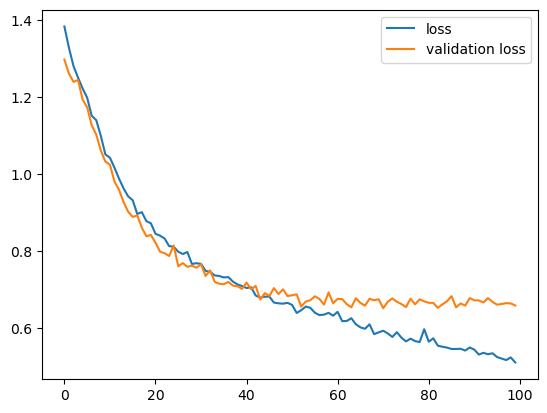

In [30]:
from matplotlib import pyplot as plt


plt.plot(model_history.history["loss"])
plt.plot(model_history.history["val_loss"])
plt.legend(["loss", "validation loss"], loc ="upper right")
plt.show()

In [33]:
print(model.evaluate(X_train_smote, y_train_smote))

57/57 [==============================] - 0s 2ms/step - loss: 0.4427 - f1_m: 0.9710
[0.4427109658718109, 0.9710094928741455]


In [31]:
print(model.evaluate(X_valid, y_valid))

7/7 [==============================] - 0s 2ms/step - loss: 0.6580 - f1_m: 0.7824
[0.6579514741897583, 0.7824237942695618]


In [32]:
print(model.evaluate(X_test, y_test))

7/7 [==============================] - 0s 2ms/step - loss: 0.6270 - f1_m: 0.7216
[0.6269993782043457, 0.7216027975082397]


![](Comparison%20of%20F1-Score%20Results%20Before%20and%20After%20Feature%20Crossing.png)